# Machine Learning Foundation

## Section 2, Part c: Cross Validation 

## Learning objectives

By the end of this lesson, you will be able to:

* Chain multiple data processing steps together using `Pipeline`
* Use the `KFolds` object to split data into multiple folds.
* Perform cross validation using SciKit Learn with `cross_val_predict` and `GridSearchCV`


In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import types
from botocore.client import Config
import ibm_boto3

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# make sure the credentials below in the def match the credentials you loaded above
def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('The file %s has been downloaded into this notebook' % key)

In [4]:
# For local file, input the name of what you want the file to be, for the key put name of the file on Cloud Object Storage
# it would be best if they match for ease
download_file_cos(credentials,'boston_housing_clean.pickle','boston_housing_clean.pickle')

The file boston_housing_clean.pickle has been downloaded into this notebook


In [5]:
# Note we are loading a slightly different ("cleaned") pickle file
boston = pickle.load(open('boston_housing_clean.pickle', "rb" ))

In [6]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [7]:
boston_data = boston['dataframe']
boston_description = boston['description']

In [8]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Discussion: 

Suppose we want to do Linear Regression on our dataset to get an estimate, based on mean squared error, of how well our model will perform on data outside our dataset. 

Suppose also that our data is split into three folds: Fold 1, Fold 2, and Fold 3.

What would the steps be, in English, to do this?

**Your response below**

#### Coding this up

The [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) object in SciKit Learn tells the cross validation object (see below) how to split up the data:

In [9]:
X = boston_data.drop('MEDV', axis=1)
y = boston_data.MEDV

In [10]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [11]:
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Test index: [ 0  2  6  9 15 17 19 23 25 26] 169

Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Test index: [ 1  3  4  5  7  8 14 16 22 27] 169

Train index: [0 1 2 3 4 5 6 7 8 9] 338
Test index: [10 11 12 13 18 20 21 24 28 31] 168



In [12]:
#from sklearn.metrics import r2_score, mean_squared_error

scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

[0.671934879847278, 0.7485020059212362, 0.6976807323597782]

A bit cumbersome, but do-able.

### Discussion (Part 2): 

Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.

What would the steps be _now_?

**Your response below**

### Coding this up

In [13]:
scores = []

lr = LinearRegression()
s = StandardScaler()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    X_train_s = s.fit_transform(X_train)
    
    lr.fit(X_train_s, y_train)
    
    X_test_s = s.transform(X_test)
    
    y_pred = lr.predict(X_test_s)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)

In [14]:
scores

[0.6719348798472715, 0.748502005921238, 0.6976807323597742]

(same scores, because for vanilla linear regression with no regularization, scaling actually doesn't matter for performance)

This is getting quite cumbersome! 

_Very_ luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.

### `Pipeline` and `cross_val_predict`

`Pipeline` lets you chain together multiple operators on your data that both have a `fit` method.

In [15]:
s = StandardScaler()
lr = LinearRegression()

### Combine multiple processing steps into a `Pipeline`

A pipeline contains a series of steps, where a step is ("name of step", actual_model). The "name of step" string is only used to help you identify which step you are on, and to allow you to specify parameters at that step.  

In [16]:
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

### `cross_val_predict`

[`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

In [17]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [18]:
predictions = cross_val_predict(estimator, X, y, cv=kf)

In [19]:
r2_score(y, predictions)

0.7063531064161559

In [20]:
np.mean(scores) # almost identical!

0.7060392060427612

Note that `cross_val_predict` doesn't use the same model for all steps; the predictions for each row are made when that row is in the validation set. We really have the collected results of 3 (i.e. `kf.num_splits`) different models. 

When we are done, `estimator` is still not fitted. If we want to predict on _new_ data, we still have to train our `estimator`. 

## Hyperparameter tuning

### Definition

**Hyperparameter tuning** involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that _generalizes_ well outside of your sample.

### Mechanics

We can generate an exponentially spaces range of values using the numpy [`geomspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html#numpy.geomspace) function.

```python
np.geomspace(1, 1000, num=4)
```

produces:

```
array([    1.,    10.,   100.,  1000.])
```

Use this function to generate a list of length 10 called `alphas` for hyperparameter tuning:

In [21]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

The code below tunes the `alpha` hyperparameter for Lasso regression.

In [22]:
scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [23]:
list(zip(alphas,scores))

[(1e-09, 0.7063531064981925),
 (1e-08, 0.7063531072356071),
 (1e-07, 0.7063531145602442),
 (1e-06, 0.7063531882052065),
 (1e-05, 0.7063539165191507),
 (0.0001, 0.706361268093463),
 (0.001, 0.706433467041546),
 (0.01, 0.7070865958083233),
 (0.1, 0.705838151167185),
 (1.0, 0.6512724532884887)]

In [24]:
Lasso(alpha=1e-6).fit(X, y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [25]:
Lasso(alpha=1.0).fit(X, y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

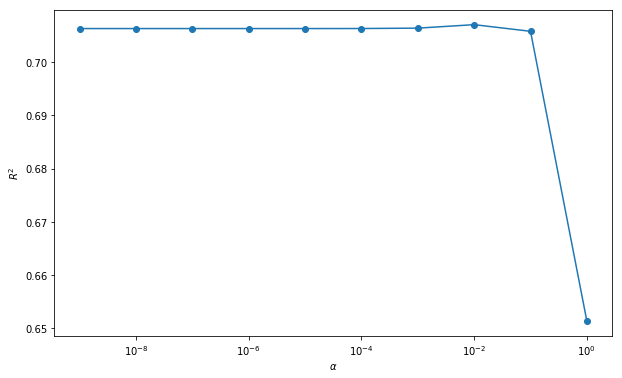

In [26]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

### Exercise

Add `PolynomialFeatures` to this `Pipeline`, and re-run the cross validation with the `PolynomialFeatures` added.

**Hint #1:** pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.

**Hint #2:** you should see a significant increase in cross validation accuracy from doing this

In [27]:
pf = PolynomialFeatures(degree=3)

scores = []
alphas = np.geomspace(0.06, 6.0, 20)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)
    

If you store the results in a list called `scores`, the following will work:

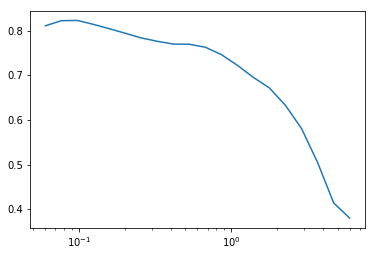

In [28]:
plt.semilogx(alphas, scores);

In [29]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9134777735196521

In [30]:
best_estimator.named_steps["lasso_regression"].coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -1.00309168e+00,  3.32679107e+00, -1.01840878e+00,
       -2.56161421e+00,  1.12778302e+00, -1.72266155e+00, -5.37088506e-01,
        4.39555878e-01, -3.39542586e+00,  7.22387712e-02,  0.00000000e+00,
        0.00000000e+00,  3.53653554e+00, -0.00000000e+00,  3.72285440e-01,
        0.00000000e+00,  0.00000000e+00, -5.49528703e-01, -0.00000000e+00,
       -0.00000000e+00, -4.05522485e-02,  2.25864611e-01,  1.78508858e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.50874606e-02,
       -0.00000000e+00, -2.07295802e-01, -0.00000000e+00,  3.71781995e-01,
        0.00000000e+00, -0.00000000e+00, -5.89531100e-02,  3.47180625e-01,
        0.00000000e+00,  9.23666274e-01,  3.48873365e-01,  7.29463442e-02,
        0.00000000e+00,  0.00000000e+00,  7.68485586e-02, -7.21083596e-01,
        0.00000000e+00, -5.98542558e-01,  4.18420677e-01, -7.98165728e-01,
       -7.25062683e-01,  

### Exercise

Do the same, but with `Ridge` regression 

Which model, `Ridge` or `Lasso`, performs best with its optimal hyperparameters on the Boston dataset?

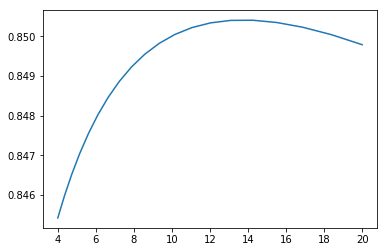

In [31]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores=[]
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores.append(score)

plt.plot(alphas, scores)

**Conclusion:** Both Lasso and Ridge with proper hyperparameter tuning give better results than plain ol' Linear Regression!

### Exercise:

Now, for whatever your best overall hyperparameter was: 

* Standardize the data
* Fit and predict on the entire dataset
* See what the largest coefficients were
    * Hint: use 
    ```python
    dict(zip(model.coef_, pf.get_feature_names()))
    ```
    for your model `model` to get the feature names from `PolynomialFeatures`.
    
    Then, use
    ```python
    dict(zip(list(range(len(X.columns.values))), X.columns.values))
    ```
    
    to see which features in the `PolynomialFeatures` DataFrame correspond to which columns in the original DataFrame.


In [32]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.01))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.9241797703677183

In [33]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(input_features=X.columns),
                 best_estimator.named_steps["lasso_regression"].coef_,
))

In [34]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [35]:
col_names_dict

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

In [36]:
df_importances.sort_values(by=1)

,0,1
90,RAD^2,-4.803638
13,LSTAT,-3.307996
8,DIS,-2.812789
7,AGE,-1.454097
85,DIS RAD,-1.431074
94,RAD LSTAT,-1.426539
73,RM TAX,-1.399134
82,AGE B,-1.355802
83,AGE LSTAT,-1.250545
5,NOX,-1.237913


## Grid Search CV

To do cross-validation, we used two techniques:
- use `KFolds` and manually create a loop to do cross-validation
- use `cross_val_predict` and `score` to get a cross-valiated score in a couple of lines.

To do hyper-parameter tuning, we see a general pattern:
- use `cross_val_predict` and `score` in a manually written loop over hyperparemeters, then select the best one.

Perhaps not surprisingly, there is a function that does this for us -- `GridSearchCV`

In [37]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [38]:
grid.fit(X, y)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomial_features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge_regression', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'polynomial_features__degree': [1, 2, 3], 'ridge_regression__alpha': array([ 4.     ,  4.22827,  4.46956,  4.72462,  4.99424,  5.27925,
        5.58052,  5.89898,  6.23562,  6.59146,  6.96761,  7.36523,
        7.78554,  8.22984,  8.69949,  9.19594,  9.72072, 10.27545,
       10.86184, 11.48169, 12.13691, 12.82953, 13.56167, 14.33559,
       15.15367, 16.01844, 16.93257, 17.89885, 18.92028, 20.     ])},
       pre_dispatch='2*n_jobs', refit=True

In [39]:
grid.best_score_, grid.best_params_

(0.8504975378207537,
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': 15.153673507519274})

In [40]:
y_predict = grid.predict(X)

In [41]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

0.9149145594213683

In [42]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00, -1.27346408e-01, -6.16205046e-03,  2.36135244e-02,
        1.00398027e-01, -9.74110586e-01,  3.26236441e+00, -9.65057238e-01,
       -1.96344725e+00,  8.56769182e-01, -1.01488960e+00, -7.06985966e-01,
        5.52029222e-01, -3.03254502e+00,  7.74127927e-02,  7.24276605e-02,
        6.82776638e-02,  1.72849044e+00, -4.80758341e-01,  5.76219972e-01,
        1.28132069e-01,  2.22931335e-01, -7.45243542e-01,  1.66582495e-01,
       -8.00025634e-02, -8.54571642e-02,  5.07490801e-01,  2.14820391e-01,
       -1.48833274e-01,  1.42098626e-01,  1.93770221e-01,  5.02304885e-02,
       -1.12667821e-01, -2.77559685e-01, -1.32870713e-01,  7.32239658e-01,
        5.26857333e-02,  8.89966580e-02, -2.72228558e-01,  5.84383917e-01,
        1.06306947e-01,  9.62971619e-01,  5.76845132e-01,  5.33378179e-01,
        7.07913980e-01, -6.21760626e-02,  7.57641545e-02, -4.28157866e-01,
        2.40651011e-01, -6.82201736e-01,  3.40931549e-01, -9.62217889e-01,
       -8.14997204e-01,  

In [43]:
pd.DataFrame(grid.cv_results_)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/Python36/

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomial_features__degree,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.004738,0.000674,0.004324,0.003960,1,4,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672111,0.748235,0.701801,0.707393,0.031357,60,0.765659,0.732051,0.743390,0.747033,0.013960
1,0.004312,0.000122,0.001523,0.000010,1,4.22827,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672103,0.748207,0.701986,0.707443,0.031337,59,0.765622,0.732017,0.743345,0.746994,0.013960
2,0.004194,0.000014,0.001516,0.000004,1,4.46956,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672093,0.748175,0.702178,0.707493,0.031316,58,0.765582,0.731979,0.743295,0.746952,0.013960
3,0.004199,0.000018,0.001569,0.000005,1,4.72462,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672081,0.748141,0.702375,0.707543,0.031295,57,0.765538,0.731938,0.743240,0.746905,0.013960
4,0.004204,0.000013,0.001580,0.000010,1,4.99424,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672067,0.748104,0.702579,0.707593,0.031273,56,0.765489,0.731894,0.743180,0.746854,0.013959
5,0.004211,0.000046,0.001526,0.000007,1,5.27925,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672050,0.748063,0.702788,0.707643,0.031251,55,0.765437,0.731844,0.743115,0.746799,0.013959
6,0.004189,0.000005,0.001525,0.000007,1,5.58052,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672030,0.748018,0.703003,0.707693,0.031228,54,0.765379,0.731791,0.743043,0.746738,0.013959
7,0.004220,0.000010,0.001526,0.000010,1,5.89898,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672007,0.747969,0.703223,0.707742,0.031205,53,0.765316,0.731732,0.742966,0.746671,0.013959
8,0.004239,0.000013,0.001562,0.000030,1,6.23562,"{'polynomial_features__degree': 1, 'ridge_regr...",0.671980,0.747915,0.703449,0.707790,0.031181,52,0.765248,0.731668,0.742881,0.746599,0.013959
9,0.004358,0.000115,0.001578,0.000027,1,6.59146,"{'polynomial_features__degree': 1, 'ridge_regr...",0.671950,0.747856,0.703679,0.707836,0.031157,50,0.765174,0.731598,0.742789,0.746520,0.013959


## Summary

1. We can manually generate folds by using `KFolds`
2. We can get a score using `cross_val_predict(X, y, cv=KFoldObject_or_integer)`. 
   This will produce the out-of-bag prediction for each row.
3. When doing hyperparameter selection, we should be optimizing on out-of-bag scores. This means either using `cross_val_predict` in a loop, or ....
4. .... use `GridSearchCV`. GridSearchCV takes a model (or pipeline) and a dictionary of parameters to scan over. It finds the hyperparameter set that has the best out-of-sample score on all the parameters, and calls that it's "best estimator". It then retrains on all data with the "best" hyper-parameters.

### Extensions

Here are some additional items to keep in mind:
* There is a `RandomSearchCV` that tries random combination of model parameters. This can be helpful if you have a prohibitive number of combinations to test them all exhaustively.
* KFolds will randomly select rows to be in the training and test folds. There are other methods (such as `StratifiedKFolds` and `GroupKFold`, which are useful when you need more control over how the data is split (e.g. to prevent data leakage). You can create these specialized objects and pass them to the `cv` argument of `GridSearchCV`.

---
### Machine Learning Foundation (C) 2020 IBM Corporation